In [1]:
x=1

In [2]:
import scanpy as sc
import pandas as pd
import decoupler as dc

from sklearn.metrics import classification_report

In [3]:
adata = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/hlca/5fold/hlca_hyperparam/data/pp/hlca_hvg_pearson.h5ad')
adata

AnnData object with n_obs × n_vars = 2149684 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_l

In [4]:
adata.X.data

array([1., 5., 1., ..., 1., 2., 3.], dtype=float32)

In [5]:
DONOR = 'sample'
CONDITION = 'lung_condition_coarse'

# Create pseudobulks

In [6]:
# Get pseudo-bulk profile
adata_ = dc.get_pseudobulk(adata, sample_col=DONOR, groups_col=None, min_prop=-1, min_smpls=0, min_cells=0, min_counts=0)
adata_

View of AnnData object with n_obs × n_vars = 709 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'lung_condition', 'mixed_ancestry', 'sample', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'lung_condition_coarse', 'split0', 'split1', 'split2', 'split3', 'split4', 'psbulk_n_cells', 'psbulk_counts'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    layers: 'psbulk_props'

# Multiclass regression

In [7]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
onehot_encoder = OneHotEncoder(sparse=False)
from scipy.special import logsumexp

In [8]:
def loss(X, Y, W):
    """
    Y: onehot encoded
    """
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(logsumexp(Z, axis=1)))
    return loss

def gradient(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + 2 * mu * W
    return gd

def gradient_descent(X, Y, max_iter=2000, eta=0.1, mu=0.01):
    """
    Very basic gradient descent algorithm with fixed eta and mu
    """
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
 
    while step < max_iter:
        step += 1
        W -= eta * gradient(X, Y_onehot, W, mu)
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss(X, Y_onehot, W))

    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W

class Multiclass:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)

In [9]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')

/tmp/ipykernel_1657616/3306668681.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')


In [10]:
val_accuracies = []
val_avg = []

for i in range(5):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    model = Multiclass()
    model.fit(X, Y)
    print(f'Train accuracy = {np.sum(model.predict(X) == Y)/len(Y)}.')
    y_pred = model.predict(x_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
        
    print('class report')
    print(df)
    
    print(f'Val accuracy = {df["f1-score"]["accuracy"]}.')
    print('===========================')
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])

print(f"Mean validation accuracy across 5 CV splits for a multiclass regression model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a multiclass regression model = {np.mean(np.array(val_avg))}.")

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Processing split = 0...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Train accuracy = 0.7319223985890653.
class report
              precision    recall  f1-score     support
0              1.000000  0.333333  0.500000    3.000000
1              0.636364  0.875000  0.736842    8.000000
2              0.481481  1.000000  0.650000   13.000000
3              0.500000  0.666667  0.571429    6.000000
4              0.800000  1.000000  0.888889    4.000000
5              0.959184  0.559524  0.706767   84.000000
6              0.055556  0.333333  0.095238    3.000000
7              0.521739  0.631579  0.571429   19.000000
8              0.000000  0.000000  0.000000    2.000000
accuracy       0.626761  0.626761  0.626761    0.626761
macro avg      0.550480  0.599937  0.524510  142.000000
weighted avg   0.783108  0.626761  0.657325  142.000000
Val accuracy = 0.6267605633802817.
Processing split = 1...
Train shapes:
x.shape = (56

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

Train accuracy = 0.7971781305114638.
class report
              precision    recall  f1-score     support
0              1.000000  0.250000  0.400000    4.000000
1              0.285714  1.000000  0.444444    4.000000
2              0.434783  0.714286  0.540541   14.000000
3              1.000000  0.400000  0.571429    5.000000
4              1.000000  0.666667  0.800000    3.000000
5              0.900000  0.684783  0.777778   92.000000
6              0.666667  0.857143  0.750000    7.000000
7              0.631579  1.000000  0.774194   12.000000
8              0.500000  1.000000  0.666667    1.000000
accuracy       0.711268  0.711268  0.711268    0.711268
macro avg      0.713194  0.730320  0.636117  142.000000
weighted avg   0.808278  0.711268  0.725106  142.000000
Val accuracy = 0.7112676056338029.
Processing split = 2...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train accuracy = 0.798941798941799.
class report
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    4.000000
1              0.250000  0.750000  0.375000    4.000000
2              0.590909  0.928571  0.722222   14.000000
3              0.666667  0.857143  0.750000    7.000000
4              0.333333  0.250000  0.285714    4.000000
5              0.906667  0.755556  0.824242   90.000000
6              0.000000  0.000000  0.000000    4.000000
7              0.428571  0.750000  0.545455   12.000000
8              0.000000  0.000000  0.000000    3.000000
accuracy       0.704225  0.704225  0.704225    0.704225
macro avg      0.352905  0.476808  0.389181  142.000000
weighted avg   0.718420  0.704225  0.695290  142.000000
Val accuracy = 0.704225352112676.
Processing split = 3...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

Train accuracy = 0.8500881834215167.
class report
              precision    recall  f1-score     support
0              0.666667  0.285714  0.400000    7.000000
1              0.000000  0.000000  0.000000    3.000000
2              0.857143  0.750000  0.800000   16.000000
3              0.812500  0.866667  0.838710   15.000000
4              0.500000  0.500000  0.500000    2.000000
5              0.813187  0.936709  0.870588   79.000000
6              0.666667  0.666667  0.666667    3.000000
7              1.000000  0.714286  0.833333   14.000000
8              0.500000  0.333333  0.400000    3.000000
accuracy       0.809859  0.809859  0.809859    0.809859
macro avg      0.646240  0.561486  0.589922  142.000000
weighted avg   0.797959  0.809859  0.794534  142.000000
Val accuracy = 0.8098591549295775.
Processing split = 4...
Train shapes:
x.shape = (568, 2000)
y.shape = (568,)
Val shapes:
x_val.shape = (141, 2000)
y_val.shape = (141,)


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train accuracy = 0.7693661971830986.
class report
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    4.000000
1              0.000000  0.000000  0.000000    5.000000
2              0.750000  0.562500  0.642857   16.000000
3              1.000000  0.636364  0.777778   11.000000
4              0.750000  0.600000  0.666667    5.000000
5              0.711712  0.975309  0.822917   81.000000
6              0.000000  0.000000  0.000000    5.000000
7              1.000000  0.500000  0.666667   10.000000
8              1.000000  0.250000  0.400000    4.000000
accuracy       0.737589  0.737589  0.737589    0.737589
macro avg      0.579079  0.391575  0.441876  141.000000
weighted avg   0.697863  0.737589  0.688635  141.000000
Val accuracy = 0.7375886524822695.
Mean validation accuracy across 5 CV splits for a multiclass regression model = 0.7179402657077215.
Mean validation weighted avg across 5 CV splits for a multiclass regression model = 0.7

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

# NN

In [11]:
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from random import sample
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [13]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [14]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')

In [16]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.00005
NUM_FEATURES = adata_.shape[1]
NUM_CLASSES = len(adata_.obs[CONDITION].cat.categories)
TRAIN_FRACTION = 0.8

Processing split = 0...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.25581 | Val Loss: 0.82709 | Train Acc: 94.400| Val Acc: 73.451
class report
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    3.000000
1              1.000000  1.000000  1.000000    8.000000
2              0.888889  0.615385  0.727273   13.000000
3              0.714286  0.833333  0.769231    6.000000
4              1.000000  0.500000  0.666667    4.000000
5              0.831683  1.000000  0.908108   84.000000
6              0.250000  0.333333  0.285714    3.000000
7              1.000000  0.526316  0.689655   19.000000
8              1.000000  0.500000  0.666667    2.000000
accuracy       0.838028  0.838028  0.838028    0.838028
macro avg      0.742762  0.589819  0.634813  142.000000
weighted avg   0.841216  0.838028  0.819096  142.000000
Accuracy on the test set = 0.8380281690140845.
Processing split = 1...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.s

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.26553 | Val Loss: 0.72141 | Train Acc: 93.933| Val Acc: 82.301
class report
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    4.000000
1              0.666667  0.500000  0.571429    4.000000
2              1.000000  0.571429  0.727273   14.000000
3              1.000000  0.400000  0.571429    5.000000
4              1.000000  1.000000  1.000000    3.000000
5              0.827273  0.989130  0.900990   92.000000
6              1.000000  0.142857  0.250000    7.000000
7              0.714286  0.833333  0.769231   12.000000
8              0.000000  0.000000  0.000000    1.000000
accuracy       0.823944  0.823944  0.823944    0.823944
macro avg      0.689803  0.492972  0.532261  142.000000
weighted avg   0.819346  0.823944  0.790116  142.000000
Accuracy on the test set = 0.823943661971831.
Processing split = 2...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.sh

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.26647 | Val Loss: 0.75871 | Train Acc: 93.733| Val Acc: 81.416
class report
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    4.000000
1              0.000000  0.000000  0.000000    4.000000
2              0.800000  0.571429  0.666667   14.000000
3              0.666667  0.571429  0.615385    7.000000
4              1.000000  0.500000  0.666667    4.000000
5              0.771930  0.977778  0.862745   90.000000
6              1.000000  0.250000  0.400000    4.000000
7              0.625000  0.416667  0.500000   12.000000
8              0.000000  0.000000  0.000000    3.000000
accuracy       0.760563  0.760563  0.760563    0.760563
macro avg      0.540400  0.365256  0.412385  142.000000
weighted avg   0.710143  0.760563  0.715174  142.000000
Accuracy on the test set = 0.7605633802816901.
Processing split = 3...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.s

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.23015 | Val Loss: 0.99385 | Train Acc: 95.400| Val Acc: 76.991
class report
              precision    recall  f1-score     support
0              0.000000  0.000000  0.000000    7.000000
1              1.000000  1.000000  1.000000    3.000000
2              0.916667  0.687500  0.785714   16.000000
3              0.833333  0.666667  0.740741   15.000000
4              0.333333  0.500000  0.400000    2.000000
5              0.760000  0.962025  0.849162   79.000000
6              1.000000  0.333333  0.500000    3.000000
7              0.909091  0.714286  0.800000   14.000000
8              0.000000  0.000000  0.000000    3.000000
accuracy       0.788732  0.788732  0.788732    0.788732
macro avg      0.639158  0.540423  0.563957  142.000000
weighted avg   0.750708  0.788732  0.755397  142.000000
Accuracy on the test set = 0.7887323943661971.
Processing split = 4...
Train shapes:
x.shape = (568, 2000)
y.shape = (568,)
Val shapes:
x_val.shape = (141, 2000)
y_val.s

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.23536 | Val Loss: 0.74113 | Train Acc: 94.133| Val Acc: 80.531
class report
              precision    recall  f1-score    support
0              0.000000  0.000000  0.000000    4.00000
1              1.000000  0.600000  0.750000    5.00000
2              0.764706  0.812500  0.787879   16.00000
3              0.600000  0.545455  0.571429   11.00000
4              0.750000  0.600000  0.666667    5.00000
5              0.785714  0.950617  0.860335   81.00000
6              0.500000  0.200000  0.285714    5.00000
7              0.857143  0.600000  0.705882   10.00000
8              0.000000  0.000000  0.000000    4.00000
accuracy       0.773050  0.773050  0.773050    0.77305
macro avg      0.584174  0.478730  0.514212  141.00000
weighted avg   0.725529  0.773050  0.738650  141.00000
Accuracy on the test set = 0.7730496453900709.
Mean validation accuracy across 5 CV splits for a NN model = 0.7968634502047747.
Mean validation weighted avg across 5 CV splits for a 

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

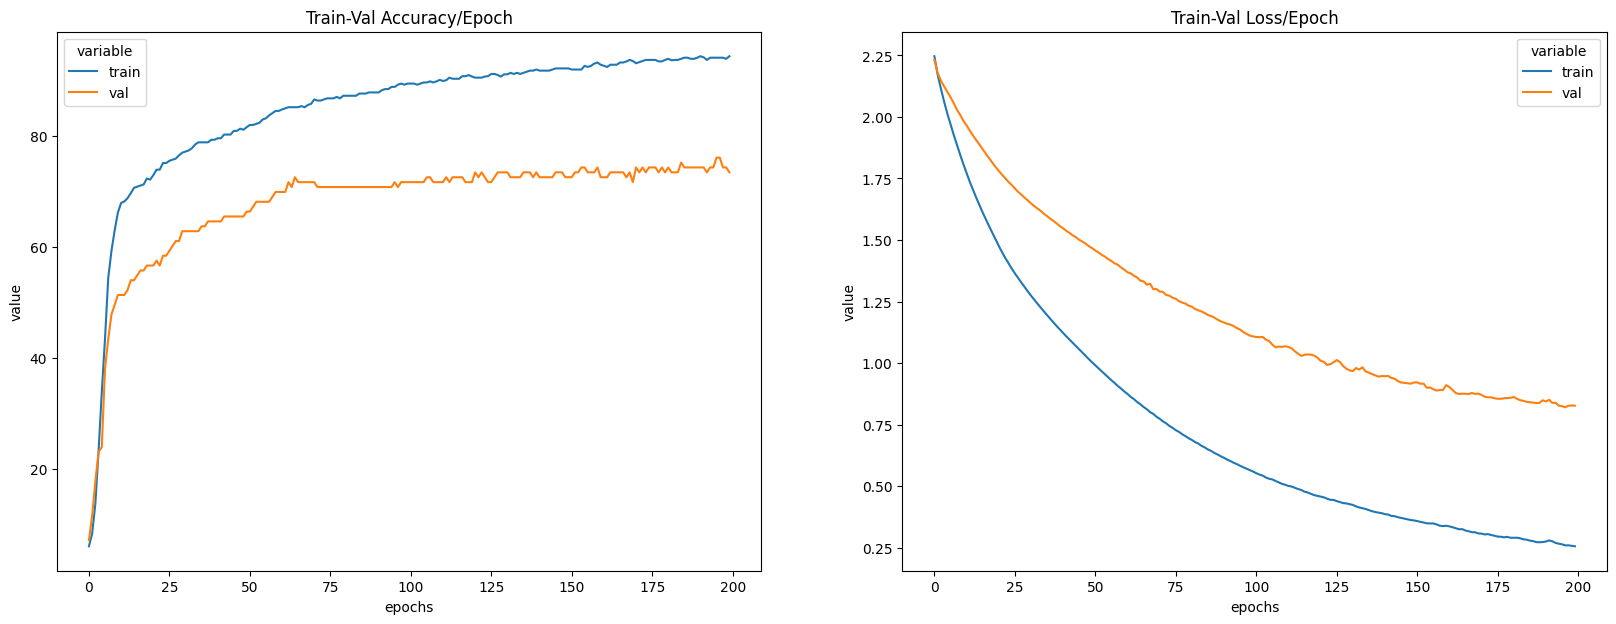

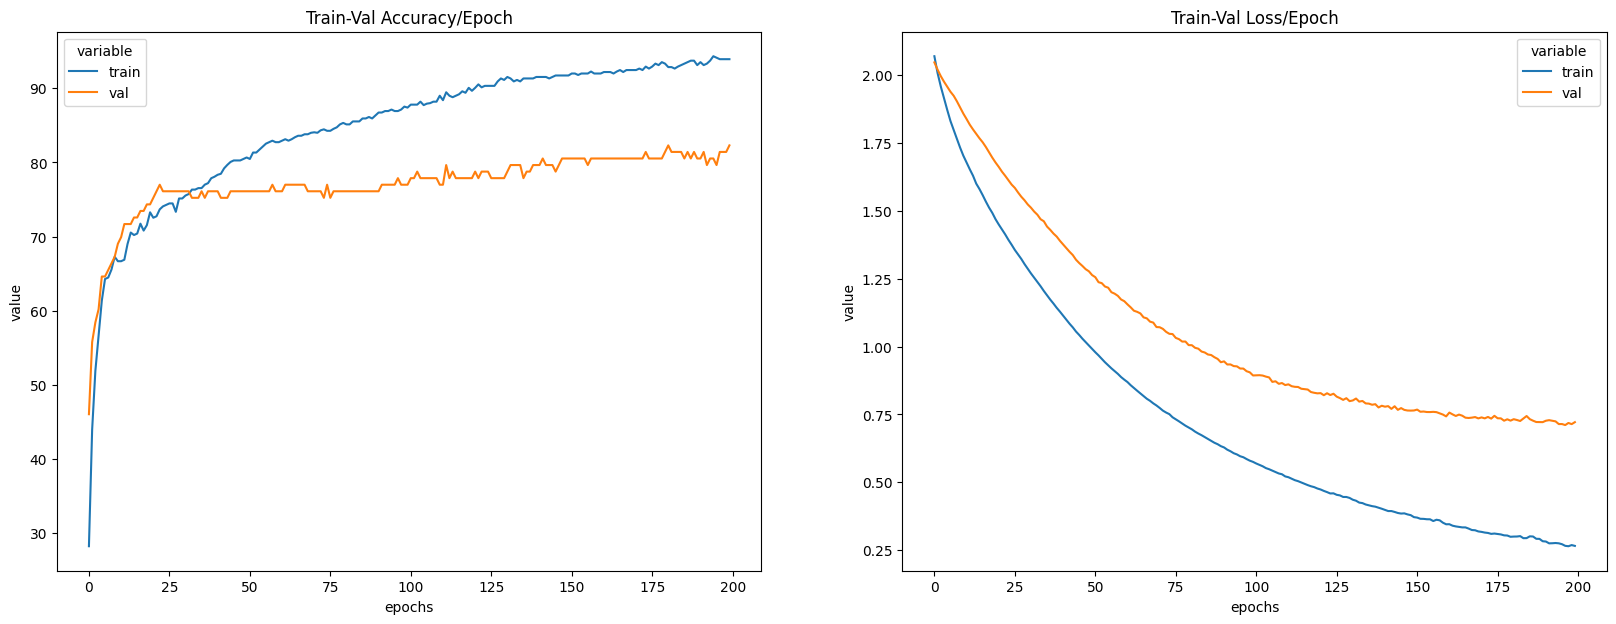

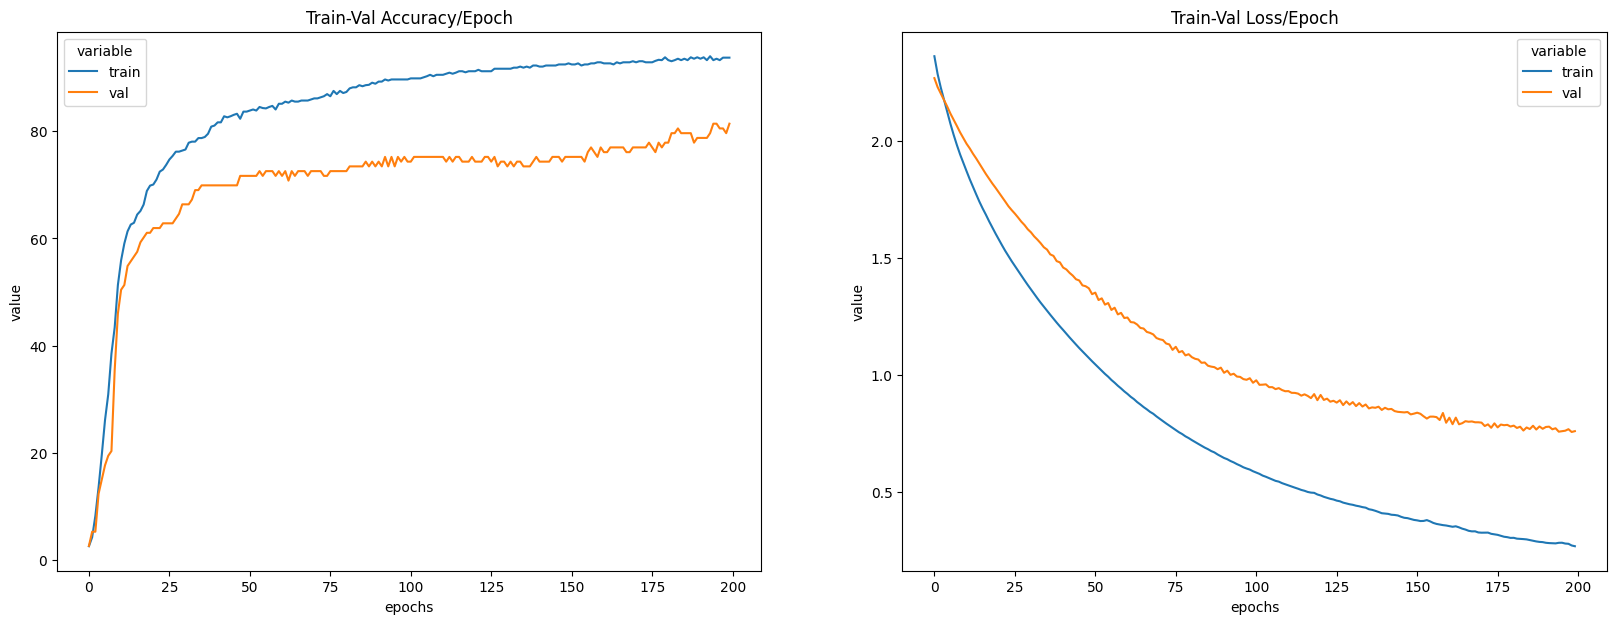

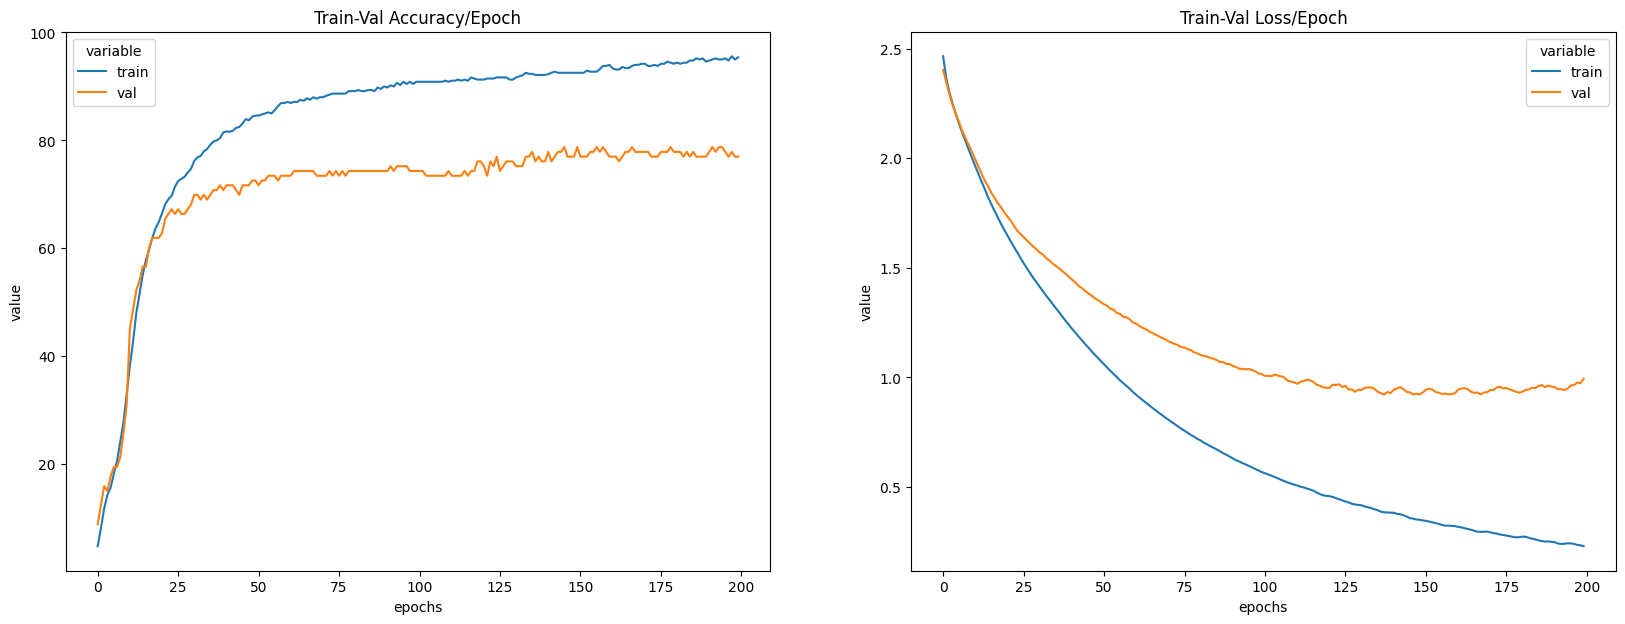

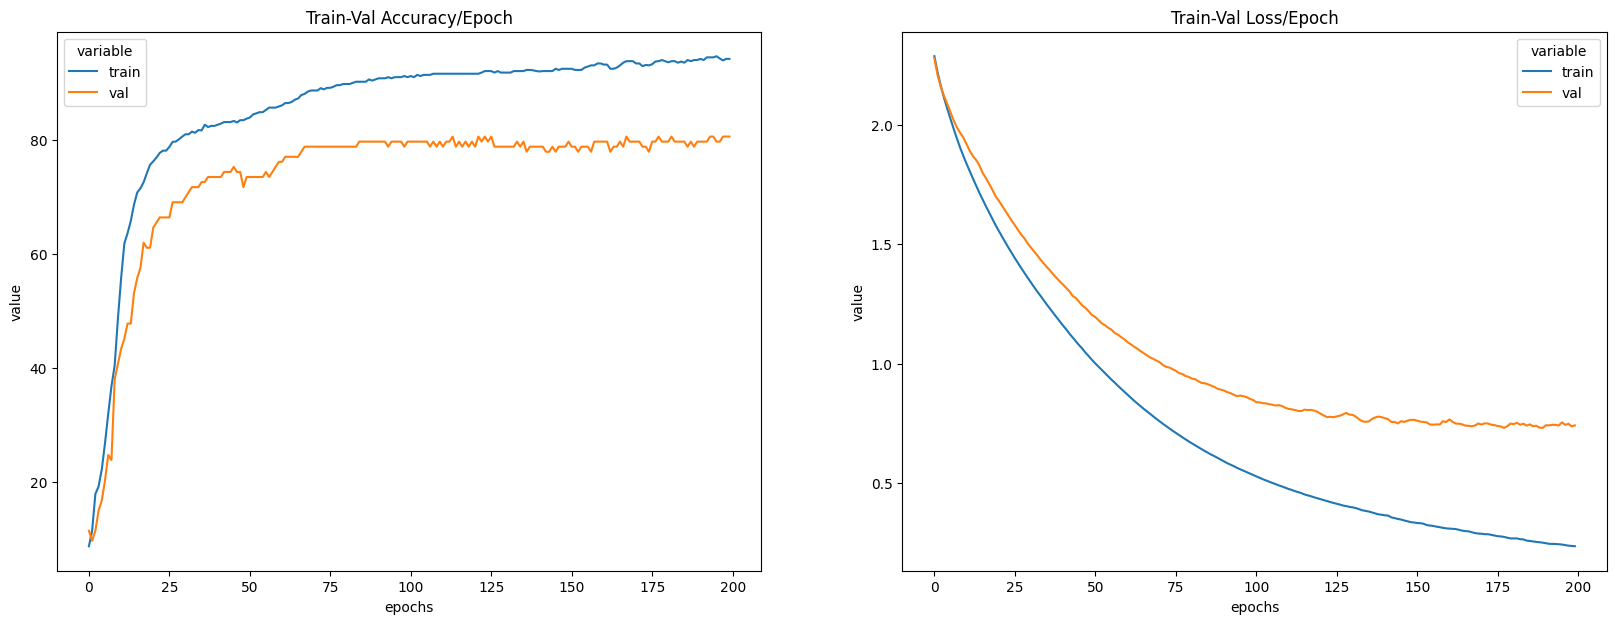

In [17]:
val_accuracies = []
val_avg = []


for i in range(5):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data, later this is called test data because the val data is subset of train
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    n_of_train_samples = int(math.ceil(len(y) * TRAIN_FRACTION))
    train_samples = sample(range(len(y)), n_of_train_samples)
    val_samples = [i for i in range(len(y)) if i not in train_samples]
    X_test = x_val
    y_test = y_val
    X_train = x[train_samples]
    y_train = y[train_samples]
    X_val = x[val_samples]
    y_val = y[val_samples]
    
    # create datasets
    train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
    
    # create loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    
    # init model
    model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    # define loss
    criterion = nn.CrossEntropyLoss()
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # loss recoder
    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }
    
    # train
    print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):

        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch, y_train_batch
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        # VALIDATION    
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch, y_val_batch

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    # losses
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
    
    # predict
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    df = classification_report(y_test, y_pred_list, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    print(f'Accuracy on the test set = {df["f1-score"]["accuracy"]}.')
    print('===========================')
    
print(f"Mean validation accuracy across 5 CV splits for a NN model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a NN model = {np.mean(np.array(val_avg))}.")


# Random forest

Adjusted from https://www.datacamp.com/tutorial/random-forests-classifier-python.

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
val_accuracies = []
val_avg = []
for i in range(5):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    clf = RandomForestClassifier(n_estimators=5)
    clf.fit(X, Y)
    print(f'Train accuracy = {np.sum(clf.predict(X) == Y)/len(Y)}.')
    y_pred = clf.predict(x_val)
    val_accuracy = np.sum(y_pred == y_val)/len(y_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    val_accuracy = df["f1-score"]["accuracy"]
    
    print(f'Val accuracy = {val_accuracy}.')
    print('===========================')


print(f"Mean validation accuracy across 5 CV splits for a random forest model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a random forest model = {np.mean(np.array(val_avg))}.")


Processing split = 0...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Train accuracy = 0.9788359788359788.
class report
              precision    recall  f1-score     support
0              0.666667  0.666667  0.666667    3.000000
1              0.800000  0.500000  0.615385    8.000000
2              0.700000  0.538462  0.608696   13.000000
3              0.833333  0.833333  0.833333    6.000000
4              0.750000  0.750000  0.750000    4.000000
5              0.810000  0.964286  0.880435   84.000000
6              0.000000  0.000000  0.000000    3.000000
7              1.000000  0.578947  0.733333   19.000000
8              0.000000  0.000000  0.000000    2.000000
accuracy       0.795775  0.795775  0.795775    0.795775
macro avg      0.617778  0.536855  0.565316  142.000000
weighted avg   0.792535  0.795775  0.779760  142.000000
Val accuracy = 0.795774647887324.
Processing split = 1...


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Train accuracy = 0.9735449735449735.
class report
              precision    recall  f1-score     support
0              0.500000  0.500000  0.500000    4.000000
1              0.500000  0.500000  0.500000    4.000000
2              0.833333  0.714286  0.769231   14.000000
3              0.750000  0.600000  0.666667    5.000000
4              1.000000  1.000000  1.000000    3.000000
5              0.852941  0.945652  0.896907   92.000000
6              1.000000  0.142857  0.250000    7.000000
7              0.818182  0.750000  0.782609   12.000000
8              1.000000  1.000000  1.000000    1.000000
accuracy       0.830986  0.830986  0.830986    0.830986
macro avg      0.806051  0.683644  0.707268  142.000000
weighted avg   0.835954  0.830986  0.815207  142.000000
Val accuracy = 0.8309859154929577.
Processing split = 2...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w